<img src="ts_moon.jpg" width="500" height="300" align="right"/>

# Time Series Analysis: SARIMA

Author: Christoph Güttner


**Abstract**  
A SARIMA (Seasonal ARIMA) processes $(1,1,1)(3,1,2)_{30}$ is  
generated and inter- and extrapolated. The model parameter are  
derived by Fourier Transformation and Grid Search. Daily data  
of one year (2020) is used to train the respective ARIMA Model  
and predict two further months (- March 2021) by i) a complete  
prediction and ii) a rolling forecast(time horizon=2).

S: Seasonal  
AR: Auto Regression  
I: Integrated  
MA: Moving Average  

**Results:** The AIC and BIC suggest slightly more complex  
models than the data generating process. However, despite the  
risk of overfitting (bias variance trade-off) the test score  
performs better than the training score.  



## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)

* [Time Series Data](#Time_Series_Data)
    * [Normalize](#Normalize)
    * [Visualise Data](#Visualise_Data)
* [Model Selection](#Model_Selection)
    * [Fourier_Transformation](#Fourier_Transformation)
    * [Grid Search](#Grid_Search)
* [Forecast](#Forecast)
    * [Prediction](#Prediction)
    * [Rolling Forcast](#Rolling_Forecast)
* [Evaluation](#Model_Selection)


## Imports

In [1]:
import numpy as np
import pandas as pd

import warnings
import time
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.statespace.sarimax import SARIMAX as SARIMA


import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
# Functions
def generate_Seasonal_ARMA(y, p, q, m, a, b, c, sigma, n_samples):
    
    epsilon = np.float64(np.random.normal(0,sigma, n_samples))

    for t in range(p+m, n_samples):
        sum = 0.0
        for i in range(1,p+1):
            sum += a[i-1] * y[(t-(i*m))]
        for j in range(1,q+1):
            epsilon[t-(j*m)] = np.float64(np.random.normal(0.0, sigma))
            sum += b[j-1] * epsilon[(t-(j*m))]
        epsilon[t] = np.float64(np.random.normal(0.0, sigma))
        y[t] = np.float64(c) + np.float64(epsilon[t]) + sum
    return np.array(y)
    


def generate_ARMA(ts, p, q, a, b, c,m, sigma, n_samples):

    epsilon = np.float64(np.zeros(n_samples))

    for t in range(p, n_samples):
        sum = 0.0
        for i in range(1,p+1):
            sum += a[i-1] * ts[t-i]
        for j in range(1,q+1):
            epsilon[t-j] = np.float64(np.random.normal(0.0, sigma))
            sum += b[j-1] * epsilon[t-j]
        epsilon[t] = np.float64(np.random.normal(0.0, sigma))
        ts[t] = np.float64(c) + np.float64(epsilon[t]) + sum

    return np.array(ts[m:])
    

def get_seasonal_integration(ts, m):
    """
    Berechnet die saisonale Integration
    """
    rv = []
    for i in range(m,len(ts)):
        # ts[i]= (ts[i-1] + ts[i-1-m])/2
        rv.append(ts[i-1] + ts[i-1-m])
    si = np.array(rv)
    return si
   

def get_seasonal_mean(ts, m):
    """
    Berechnet den saisonalen Mittelwert
    """
    rv = []
    for i in range(m,len(ts)):
        # ts[i]= (ts[i-1] + ts[i-1-m])/2
        rv.append((ts[i-1] + ts[i-1-m])/3.0)
    return rv


def get_integration_order(ts, n_order):
    for i in range(n_order):
        ts = np.cumsum(np.array(ts))
    return np.array(ts)
    

def normalise(data):
    mean=data.mean()
    std = data.std()
    return (data-mean)/ std

def dickey_fuller(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

def grid_search_SARIMA(data, pdq, seasonal_pdq):
    Param=[]
    Param_seasonal=[]
    AIC=[]
    BIC=[] 
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            Param.append(param)
            Param_seasonal.append(param_seasonal)
            AIC.append(results.aic)
            BIC.append(results.bic)
    return Param, Param_seasonal, AIC, BIC

def rolling_forecast_SARIMA(df, params,params_s, train_len, test_len):
    start = df.iloc[train_len, [0]]
    rolling_predictions = [start]
    for i in range(test_len-1):
        train = df.iloc[:(train_len+i), [0]]
        model = sm.tsa.statespace.SARIMAX(train,
                                order=params,
                                seasonal_order=params_s,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        model_fit = model.fit()                       
        pred = model_fit.forecast(horizon=2)
        rolling_predictions.append(pred.values[0])
    return np.array(rolling_predictions).astype(float)


## Time_Series_Data

In [3]:
date_index = pd.date_range(start='1/1/2020', end='3/1/2021')
n_samples = len(date_index)
n_samples

426

## Model Parameter

In [4]:

sigma = 1.0
y = np.float64(np.random.normal(0,sigma, n_samples))
#parameter for SARIMA
p1=1
q1=1
a1=[0.66]
b1=[0.06]
#parameter for ARIMA
p=3
q=2
a=[0.45, 0.46, 0.03]
b=[0.02, 0.07]

c=0.0

np.random.seed(42)
params=(1,1,1)
params_s=(3,1,2,30)



## SARIMA Process: $(1,1,1)*(3,1,2)_{30}$


In [5]:
n_order=1
m=30


data1 = generate_ARMA(y, p1, q1, a1, b1, c, m,sigma,n_samples)
data1 = get_integration_order(data1, n_order)

data2 = generate_Seasonal_ARMA(y, p, q,m, a, b, c, sigma,n_samples)
data2 = get_seasonal_integration(data2, m)



data_mult = data1 * data2


### Normalise

In [6]:
data_normal = normalise(data_mult)

In [7]:
index= date_index[m:]
dict_data={'data':data_normal}
df_data= pd.DataFrame(dict_data, index=index)

### Visualise_Data

<Figure size 1080x360 with 0 Axes>

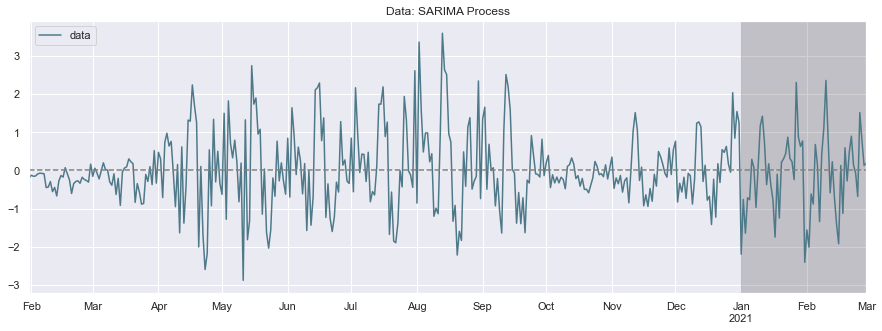

In [8]:
plt.figure(facecolor='#D0CCAF', figsize=(15,5))
#plt.plot(data, color='#9A352D', label='data') 
df_data.plot(figsize=(15,5),color='#4E7989' )
plt.title('Data: SARIMA Process')
plt.axhline(0, linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)


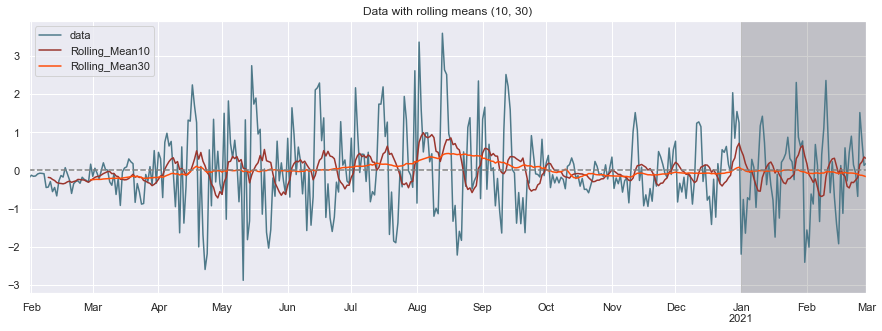

In [9]:
df_data['Rolling_Mean10'] = df_data['data'].rolling(window = 10).mean()
df_data['Rolling_Mean30'] = df_data['data'].rolling(window = 30).mean()


df_data.plot(figsize=(15,5),color=['#4E7989', '#9A352D', '#FF4E0B'] )
plt.title('Data with rolling means (10, 30)')
plt.axhline(0, linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)

## Model_Selection
### Train Test Split


In [10]:
df_train = df_data['data'][:'1/1/2021']
df_test = df_data['data']['1/1/2021':'3/1/2021']

In [11]:
train_len = len(df_train)
test_len = len(df_test)

train_len, test_len 

(337, 60)

### Fourier_Transformation

In [12]:
freq = np.fft.fftfreq(df_data['data'].index[:256].shape[-1]) #256=2**6
sp = np.fft.fft(df_data['data'][:256])

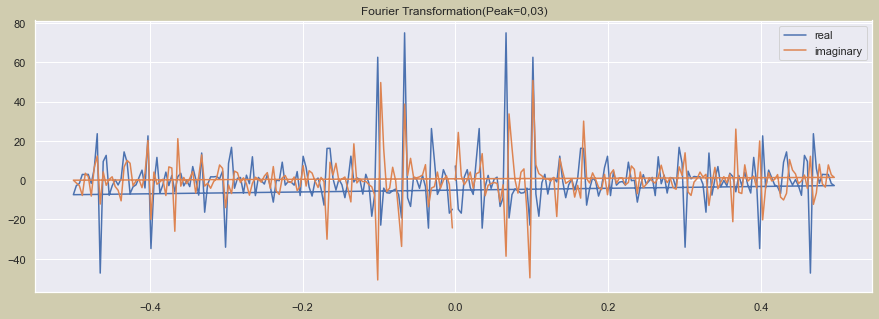

In [13]:

plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(freq, sp.real,label='real')
plt.plot(freq, sp.imag, label='imaginary')
plt.title('Fourier Transformation(Peak=0,03)')
plt.legend()
plt.show()

### Get Frequency

In [14]:
# The frequency is 1/peak

1 / 0.03333333333

30.000000003

### Grid Search

In [15]:
# Define the p, d and q parameters to take any value between 0 and 3
p = range(1,4)
d = range(1,2) 
q = range(1,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
Param, Param_seasonal, AIC, BIC = grid_search_SARIMA(df_train, pdq, seasonal_pdq)

In [61]:
dic_info={'Param':Param, 'Param_seasonal':Param_seasonal, 'AIC':AIC, 'BIC':BIC}
df_info=pd.DataFrame(dic_info)
df_info.head(3)


,Param,Param_seasonal,AIC,BIC
0,"(1, 1, 1)","(1, 1, 1, 30)",525.233137,543.298778
1,"(1, 1, 1)","(1, 1, 2, 30)",411.473256,432.456266
2,"(1, 1, 1)","(2, 1, 1, 30)",432.436680,453.444230


## Information Criteria

### Original

In [63]:
df_info.iloc[[5], :]

,Param,Param_seasonal,AIC,BIC
5,"(1, 1, 1)","(3, 1, 2, 30)",362.646646,389.61175


### AIC

In [44]:
AIC_min=df_info[df_info['AIC']==df_info['AIC'].min()]
AIC_min

,Param,Param_seasonal,AIC,BIC
34,"(3, 1, 2)","(3, 1, 1, 30)",349.177694,382.790616


### BIC

In [45]:
BIC_min = df_info[df_info['BIC']==df_info['BIC'].min()]
BIC_min



,Param,Param_seasonal,AIC,BIC
28,"(3, 1, 1)","(3, 1, 1, 30)",351.360249,381.611879


## Get_Params

In [53]:
if AIC_min.index==BIC_min.index:
    params= list(AIC_min['Param'].values)[0]
    params_s = list(AIC_min['Param_seasonal'].values)[0]
else:
    params= list(BIC_min['Param'].values)[0]
    params_s = list(BIC_min['Param_seasonal'].values)[0]

params, params_s # Here, we continue with the BIC suggestion


((3, 1, 1), (3, 1, 1, 30))

## Model_Building



In [31]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=params,
                                seasonal_order=params_s,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model = mod.fit()
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.2509,0.071,3.536,0.000,0.112,0.390
ar.L2,0.2162,0.064,3.402,0.001,0.092,0.341
ar.L3,-0.1507,0.072,-2.104,0.035,-0.291,-0.010
ma.L1,-1.0236,0.018,-56.778,0.000,-1.059,-0.988
ar.S.L30,-0.2878,0.124,-2.329,0.020,-0.530,-0.046
ar.S.L60,-0.3577,0.054,-6.685,0.000,-0.463,-0.253
ar.S.L90,-0.0155,0.064,-0.241,0.809,-0.142,0.111
ma.S.L30,0.2786,0.139,1.999,0.046,0.005,0.552
sigma2,0.2628,0.026,9.956,0.000,0.211,0.315


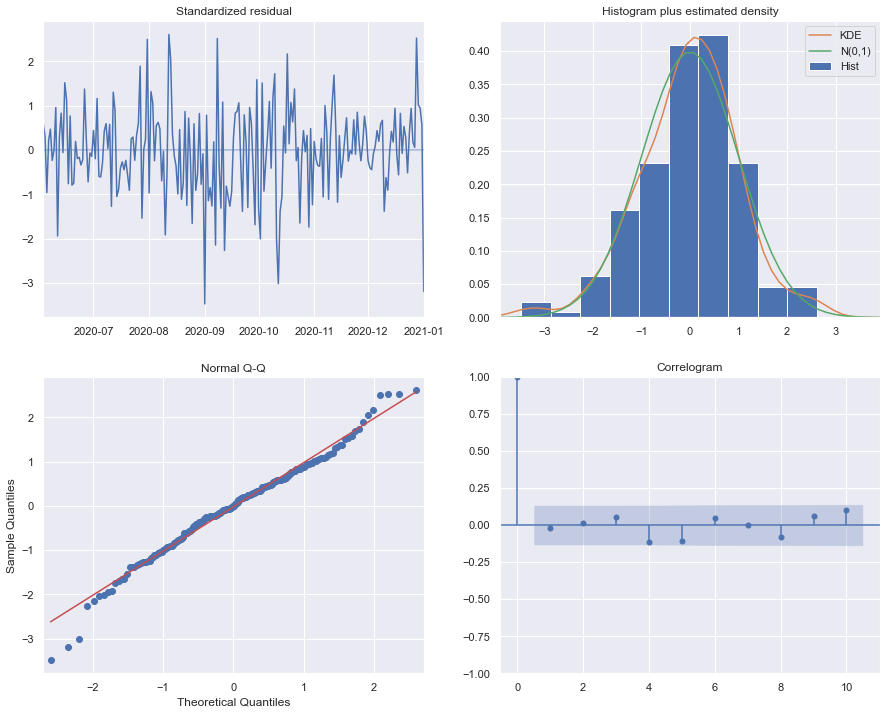

In [32]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Forecasts

### Prediction (over 60 timesteps at once)

In [33]:
start = df_train.index.min()
end = df_test.index.max()

pred = model.get_prediction(start=start, end=end)
forecast = model.get_forecast(steps=60)

pred_mean= pred.predicted_mean
rf_sdt = forecast.conf_int()


In [34]:
pred_dict = {'Model_Prediction':pred_mean}
df_pred = pd.DataFrame(pred_dict, index=df_data.index)
df_prediction =pd.concat([df_data.iloc[:,[0]], df_pred], axis=1)

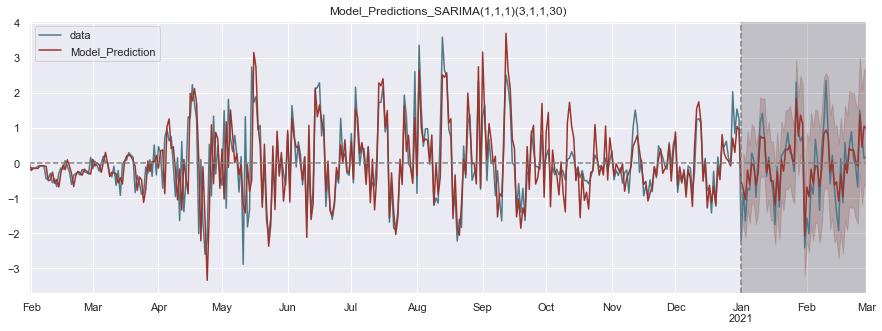

In [54]:
ax=df_prediction.plot(figsize=(15,5), color=['#4E7989', '#9A352D'])
ax.fill_between(rf_sdt.index,
                rf_sdt.iloc[:, 0],
                rf_sdt.iloc[:, 1], color='#9A352D', alpha=0.2)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.title('Model_Predictions_SARIMA(1,1,1)(3,1,1,30)')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.show()

## Rolling_Forecast

over a horizon of 2 timesteps until 60 timesteps are reached

In [36]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

rolling_forecast = rolling_forecast_SARIMA(df_data, params,params_s, train_len, test_len)

In [37]:
rf = {'Model_Prediction':rolling_forecast}
df_rolling_forecast = pd.DataFrame(rf, index=df_test.index)
df_horizon =pd.concat([df_data.iloc[:,[0]], df_rolling_forecast], axis=1)

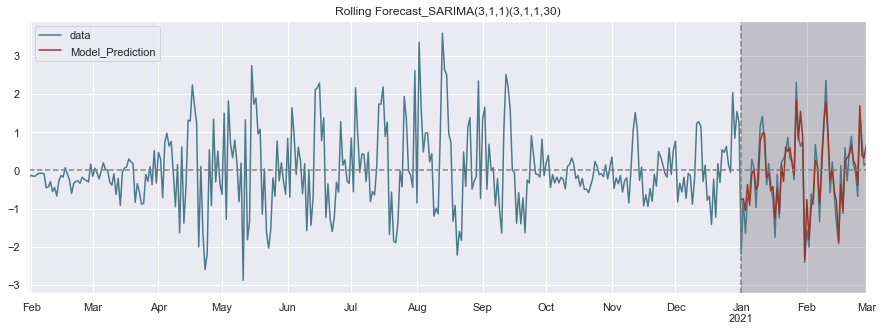

In [52]:
df_horizon.plot(figsize=(15,5), color=['#4E7989', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.title('Rolling Forecast_SARIMA(3,1,1)(3,1,1,30)')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.show()

## Evaluation

### Mean Squared Error(Model)

In [55]:
true = df_train.values
model_performance = df_pred[:'1/1/2021'].values


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the model is {}'.format(round(mse, 2)))

The Mean Squared Error of the model is 2.04


In [60]:
len(true), len(model_performance)

(60, 60)

### Mean Squared Error(Prediction)

In [57]:
# Extract the predicted and true values of our time series
true = df_test.values
model_performance = df_pred['1/1/2021':].values


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of the prediction is 1.6


### Mean Squared Error(Rolling Forecast)

In [59]:
true = df_test.values
model_performance = df_rolling_forecast['1/1/2021':].values


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the rolling forcast is {}'.format(round(mse, 2)))

The Mean Squared Error of the rolling forcast is 1.83
